<a href="https://colab.research.google.com/github/Nacho2904/pasantiacsc/blob/main/regresion_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Consigna

1) Encontrar la solución óptima invirtiendo la matriz, calcular el ECM y graficar la regresión elegida sobre un scatter plot / hecho

2) Predecir ganancias para 35.000 habitantes / hecho

3opt) Graficar el problema de optimización en 3-D (bias - weight y Risk) para todos los theta posibles / hecho

4) Resolver el problema con GD (repetir 1 y 2) / hecho

5) Plotear riesgo vs epochs / hecho

6) Chequear el LR óptimo / hecho

7) Repetir para dataset inmobiliaria

# Imports de librerías usadas

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
#sirve para gráficos tridimensionales
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
GANANCIAS = 1
POBLACION = 0

#Dataset: McDonalds

## A la vieja usanza

In [2]:
from urllib import request
example1_url="https://raw.githubusercontent.com/CSC-CONICET/CURSO-LEARNING1/main/datasets/mc.txt"
f = request.urlopen(example1_url)
#transformo el dataset directamente en matriz
dataset = np.matrix(np.loadtxt(f, dtype=float, delimiter=","))

In [3]:
  # separamos las ganancias del dataset
  Y = dataset[:,GANANCIAS]

In [4]:
#Separamos la matrix X de inputs del dataset y le anadimos la columna de unos
population = dataset[:,0]
#en realidad lo que hago es crear una matriz de nx1 llena de unos y mediante el método
#np.append le agrego la matrix X 
X = np.append(np.ones(len(dataset)).reshape(len(dataset),1), dataset[:,POBLACION], axis=1)

Calculamos la seudoinversa mediante la formula derivada

In [5]:
XtX = np.matmul(np.transpose(X), X)
seudoinversa = np.matmul(np.linalg.inv(XtX), np.transpose(X))

Finalmente, calculamos los pesos 

In [6]:
#saco w,b aplicando la fórmula derivada (XtX)^(-1)Xt*y
w = np.matmul(seudoinversa, Y)
w

matrix([[-3.89578088],
        [ 1.19303364]])

In [7]:
#función lineal, el regresor óptimo
phi = lambda x: float(w[0,0] + w[1,0]*x)

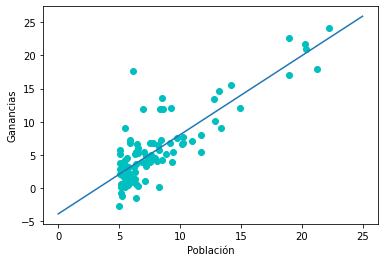

In [8]:
xaxis = np.arange(0, 25, 0.01)
yaxis = np.array([phi(x) for x in xaxis])
plt.plot(xaxis, yaxis)
plt.scatter(np.array(dataset[:,POBLACION]),np.array(dataset[:,GANANCIAS]), c='c')
plt.xlabel("Población")
plt.ylabel("Ganancias");

### Calculamos el error cuadratico medio

In [9]:
#casteo a float en la función para que el output no sea una matriz
ecm = float((1/len(dataset))*sum([(Y[i] - phi(dataset[i,0]))**2 for i in range(0,len(dataset))]))
ecm

8.953942751950358

### Prediccion para 35k habitantes

In [10]:
optimal_prediction = phi(35000)
optimal_prediction

41752.28176575754

3: Grafico del riesgo empirico para cada $(x,y) \in \mathbb{R}^2$

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


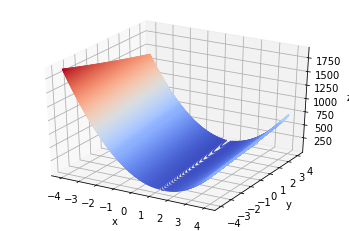

In [11]:
from matplotlib import cm

def f(x, y):
    """
    El objetivo de esta función es generalizar el cálculo del ECM para cualquier par (x,y) de reales,
    en donde y es tomado como el bias y x es tomado como el weight. La salida, el ECM, es el riesgo
    empírico del modelo.
    """
    return (1/len(dataset))*sum([(dataset[i,POBLACION] - (y + x*dataset[i,GANANCIAS]))**2 for i in range(0,len(dataset))])

#Toma 100 valores entre -4 y 4 para los ejes x,y
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)

# Crea un grid a partir de los ejes x,y
X, Y = np.meshgrid(x, y)
#Calcula el riesgo empírico para cada pareja x,y en el cuadrado [-4,4]x[-4,4]
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 1000, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');



##Usando tf

In [12]:
X = dataset[:,POBLACION]
Y = dataset[:,GANANCIAS]

In [13]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Dense(1, input_dim=1))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Con learning rate arbitrario

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.008),loss='MeanSquaredError')
hist = model_1.fit(x=X, y=Y, batch_size = 97, epochs=100000,callbacks=[es]);

Epoch 1/100000
1/1 [==============================] - 1s 694ms/step - loss: 423.3549
Epoch 2/100000
1/1 [==============================] - 0s 26ms/step - loss: 52.9884
Epoch 3/100000
1/1 [==============================] - 0s 24ms/step - loss: 16.0876
Epoch 4/100000
1/1 [==============================] - 0s 12ms/step - loss: 12.3968
Epoch 5/100000
1/1 [==============================] - 0s 14ms/step - loss: 12.0135
Epoch 6/100000
1/1 [==============================] - 0s 17ms/step - loss: 11.9597
Epoch 7/100000
1/1 [==============================] - 0s 20ms/step - loss: 11.9388
Epoch 8/100000
1/1 [==============================] - 0s 12ms/step - loss: 11.9212
Epoch 9/100000
1/1 [==============================] - 0s 13ms/step - loss: 11.9041
Epoch 10/100000
1/1 [==============================] - 0s 10ms/step - loss: 11.8871
Epoch 11/100000
1/1 [==============================] - 0s 14ms/step - loss: 11.8702
Epoch 12/100000
1/1 [==============================] - 0s 12ms/step - loss: 11.8534

Se necesitaron alrededor de 1600 epochs para completar el entrenamiento

In [15]:
param = model_1.get_weights()
param

[array([[1.188985]], dtype=float32), array([-3.8554802], dtype=float32)]

Notamos que dio algo extremadamente similar al resultado analíticamente obtenido mediante cálculo de la seudoinversa

Entrenamiento de un segundo modelo idéntico, con learning rate optimo

In [16]:
eigenvalues,eigenvectors = np.linalg.eig(XtX)
lambda_max = max(eigenvalues)
lambda_min = min(eigenvalues)
alpha_optimo = (len(dataset)/(lambda_max + lambda_min))
alpha_optimo

0.01213534165664063

In [17]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(1, input_dim=1))
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=alpha_optimo),loss='MeanSquaredError')
hist_2 = model_2.fit(x=X, y=Y, batch_size = 97, epochs=100000,callbacks=[es]);

Epoch 1/100000
1/1 [==============================] - 1s 558ms/step - loss: 20.8657
Epoch 2/100000
1/1 [==============================] - 0s 7ms/step - loss: 20.7617
Epoch 3/100000
1/1 [==============================] - 0s 6ms/step - loss: 20.6586
Epoch 4/100000
1/1 [==============================] - 0s 6ms/step - loss: 20.5564
Epoch 5/100000
1/1 [==============================] - 0s 6ms/step - loss: 20.4551
Epoch 6/100000
1/1 [==============================] - 0s 6ms/step - loss: 20.3547
Epoch 7/100000
1/1 [==============================] - 0s 6ms/step - loss: 20.2551
Epoch 8/100000
1/1 [==============================] - 0s 6ms/step - loss: 20.1565
Epoch 9/100000
1/1 [==============================] - 0s 6ms/step - loss: 20.0587
Epoch 10/100000
1/1 [==============================] - 0s 13ms/step - loss: 19.9617
Epoch 11/100000
1/1 [==============================] - 0s 13ms/step - loss: 19.8656
Epoch 12/100000
1/1 [==============================] - 0s 11ms/step - loss: 19.7703
Epoch 13

Con learning rate óptimo terminamos el entrenamiento en alrededor de 1300 epochs

Entrenamiento de un tercer modelo igual que los anteriores, pero normalizando las entradas y calculando el $\alpha$ optimo

In [18]:
mu_k = (1/len(dataset))*sum(X)
sigma_k = math.sqrt((1/len(dataset))* sum([(X[i] - mu_k)**2 for i in range(0,len(dataset))]))
mu_k, sigma_k

(matrix([[8.1598]]), 3.8498839959227156)

In [19]:
X_normalized = np.array([(x-mu_k)/sigma_k for x in X]).reshape(len(X), 1)
XtX_normalized = np.matmul(np.transpose(X), X)
eigenvalues_normalized,eigenvectors_normalized = np.linalg.eig(XtX_normalized)
lambda_max_normalized = max(eigenvalues_normalized)
lambda_min_normalized = min(eigenvalues_normalized)
alpha_optimo_normalized = (len(dataset)/(lambda_max_normalized + lambda_min_normalized))
alpha_optimo_normalized

0.006142208628554187

In [20]:
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Dense(1, input_dim=1))
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model_3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=alpha_optimo_normalized),loss='MeanSquaredError')
hist_3 = model_3.fit(x=X_normalized, y=Y, batch_size = 97, epochs=100000,callbacks=[es]);

Epoch 1/100000
1/1 [==============================] - 0s 358ms/step - loss: 58.6199
Epoch 2/100000
1/1 [==============================] - 0s 14ms/step - loss: 57.4072
Epoch 3/100000
1/1 [==============================] - 0s 12ms/step - loss: 56.2241
Epoch 4/100000
1/1 [==============================] - 0s 6ms/step - loss: 55.0699
Epoch 5/100000
1/1 [==============================] - 0s 6ms/step - loss: 53.9438
Epoch 6/100000
1/1 [==============================] - 0s 10ms/step - loss: 52.8452
Epoch 7/100000
1/1 [==============================] - 0s 15ms/step - loss: 51.7735
Epoch 8/100000
1/1 [==============================] - 0s 16ms/step - loss: 50.7279
Epoch 9/100000
1/1 [==============================] - 0s 16ms/step - loss: 49.7079
Epoch 10/100000
1/1 [==============================] - 0s 10ms/step - loss: 48.7128
Epoch 11/100000
1/1 [==============================] - 0s 14ms/step - loss: 47.7419
Epoch 12/100000
1/1 [==============================] - 0s 17ms/step - loss: 46.7948
Ep

Con normalización y learning rate óptimo terminamos el entrenamiento en alrededor de 550 epochs

In [21]:
losses_1 = np.array(hist.history['loss'])
losses_2 = np.array(hist_2.history['loss'])
losses_3 = np.array(hist_3.history['loss'])

Plots de riesgo vs epochs en los 3 modelos entrenados

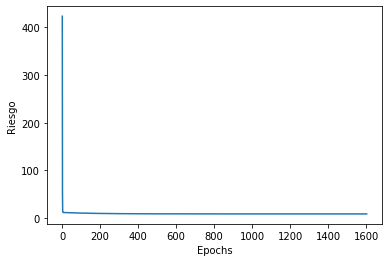

In [22]:
x_axis_1 = np.arange(1,len(losses_1)+1,1)
plt.plot(x_axis_1, losses_1)
plt.xlabel("Epochs")
plt.ylabel("Riesgo");

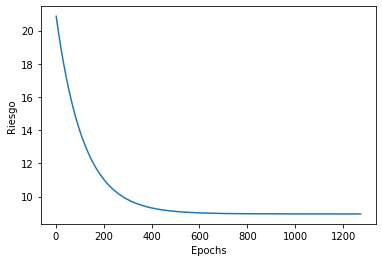

In [23]:
x_axis_2 = np.arange(1, len(losses_2)+1, 1)
plt.plot(x_axis_2, losses_2)
plt.xlabel("Epochs")
plt.ylabel("Riesgo");

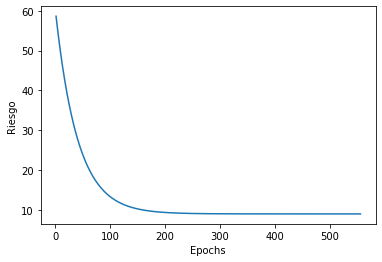

In [24]:
x_axis_3 = np.arange(1, len(losses_3)+1, 1)
plt.plot(x_axis_3, losses_3)
plt.xlabel("Epochs")
plt.ylabel("Riesgo");

In [25]:
prediction = float(model_3.predict(x=np.array([(35000-mu_k)/sigma_k])))
prediction

41715.109375

In [26]:
abs(optimal_prediction - prediction)

37.172390757543326

Vemos que la diferencia entre la predicción obtenida por el regresor óptimo obtenido analíticamente y el modelo entrenado por GD es alrededor de 40 dólares, una diferencia pequeña teniendo en cuenta que estamos en las escala de las decenas de miles.

# Dataset: Inmobiliaria

## Extracción de los datos


In [27]:
datos_inmobiliaria = pd.read_csv("https://raw.githubusercontent.com/CSC-CONICET/CURSO-LEARNING1/main/datasets/inmobiliaria.txt")
datos_inmobiliaria.loc[len(datos_inmobiliaria)] = [2104, 3, 399900]
datos_inmobiliaria.columns = ["Superficie", "Habitaciones", "Precio"]
datos_inmobiliaria.head()

,Superficie,Habitaciones,Precio
0,1600,3,329900
1,2400,3,369000
2,1416,2,232000
3,3000,4,539900
4,1985,4,299900


## A la vieja usanza

In [28]:
A_COLUMNA = (len(datos_inmobiliaria),1)
datos_superficies = np.array(datos_inmobiliaria["Superficie"]).reshape(A_COLUMNA)
datos_habitaciones = np.array(datos_inmobiliaria["Habitaciones"]).reshape(A_COLUMNA)
Y = np.matrix(datos_inmobiliaria["Precio"]).reshape(A_COLUMNA)

### Normalizo los datos

In [29]:
mu_s = (1/len(datos_inmobiliaria))*sum(datos_superficies)
mu_h = (1/len(datos_inmobiliaria))*sum(datos_habitaciones)
sigma_s = math.sqrt((1/len(datos_inmobiliaria))* sum([(datos_superficies[i] - mu_s)**2 for i in range(0,len(datos_inmobiliaria))]))
sigma_h = math.sqrt((1/len(datos_inmobiliaria))* sum([(datos_habitaciones[i] - mu_h)**2 for i in range(0,len(datos_inmobiliaria))]))
normalize = lambda x,mu,sigma : (x-mu)/sigma
datos_superficies_norm = normalize(datos_superficies, mu_s, sigma_s)
datos_habitaciones_norm = normalize(datos_superficies, mu_h, sigma_h)

In [30]:
X = np.append(np.ones(len(datos_inmobiliaria)).reshape(A_COLUMNA), datos_superficies_norm, axis=1)
X = np.append(X, datos_habitaciones_norm, axis=1) 

In [31]:
XtX = np.matmul(np.transpose(X), X)
seudoinversa = np.matmul(np.linalg.inv(XtX), np.transpose(X))

In [32]:
w = np.matmul(seudoinversa, Y)
b = w[0,0]
w_1 = w[1,0]
w_2 = w[2,0]
phi = lambda x: float(b + w_1*normalize(x[0],mu_s,sigma_s) + w_2*normalize(x[1],mu_h,sigma_h))
w

matrix([[3.50792070e+05],
        [1.13735990e+05],
        [4.81730189e+01]])

In [33]:
optimal_prediction = phi(np.array([[1650],[3]]))
optimal_prediction

300049.938673789

### Plot del plano de regresión y scatterplot

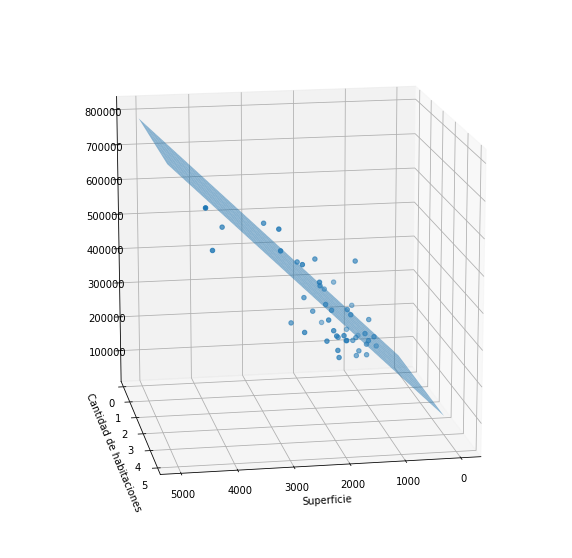

In [34]:
def f(x, y):
    return b + w_1*normalize(x,mu_s,sigma_s) + w_2*normalize(y,mu_h,sigma_h)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(datos_superficies, datos_habitaciones, Y)
fig.set_size_inches(10, 10)

xx, yy = np.meshgrid(range(5000), range(5))
z = f(xx,yy)
ax.plot_surface(xx, yy, z, alpha=0.5)
ax.view_init(15, 80)

ax.set_xlabel('Superficie')
ax.set_ylabel('Cantidad de habitaciones')
plt.show()

### Cálculo del ECM

In [35]:
ecm = float((1/len(datos_inmobiliaria))* \
            sum([(Y[i] - phi([datos_superficies[i], datos_habitaciones[i]]))**2 for i in range(0,len(datos_inmobiliaria))]))
ecm

4288415614.10811

Nota: creo que es demasiado grande. Checkear mejor luego de entrenar el modelo con tf. Posibles razones de que sea tan grande: Los datos son fuertemente no lineales, pocos datos (no debería ser muy significante en realidad), error mío de cálculo o en el ecm o antes (espero que no). También es obvio que un error "pequeño" acá como del un 10% de diferencia entre el valor real y predicción significa un aumento considerable del ecm por las simples magnitudes de los números.

Nota2: Underfitting en acción? Quizá sea a propósito

In [36]:
phi([datos_superficies[0], datos_habitaciones[0]]), Y[0]

(292816.6894266837, matrix([[329900]]))

## Usando tf